In [1]:
import numpy as np
from sklearn.metrics import mutual_info_score
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd
import seaborn as sns

In [2]:
np.random.seed(42)

In [3]:
# Function defined for MI calculation based on joint and marginal probabilities
def mutual_information(X, Y):
    # Get joint distribution (joint probability)
    joint_prob = Counter(zip(X, Y))
    total_samples = len(X)
    
    # Convert joint counts to probabilities
    for key in joint_prob:
        joint_prob[key] /= total_samples
    
    # Marginal distributions
    prob_X = Counter(X)
    prob_Y = Counter(Y)
    
    # marginal frequencies to marginal probabilities
    for key in prob_X:
        prob_X[key] /= total_samples
    for key in prob_Y:
        prob_Y[key] /= total_samples

    # Mutual Information calculation
    mi = 0.0
    for (x_val, y_val), p_xy in joint_prob.items():
        p_x = prob_X[x_val]
        p_y = prob_Y[y_val]
        mi += p_xy * np.log(p_xy / (p_x * p_y))

    # Convert to base 2
    return mi / np.log(2)

In [4]:
# Jackknife resampling for mutual information
def jackknife_mi(X, Y, mi_function):
    n = len(X)
    mi_values = []
    
    # Leave one out each time and calculate MI
    for i in range(n):
        # Remove the ith element from X and Y
        X_jack = np.delete(X, i)
        Y_jack = np.delete(Y, i)
        
        # Compute mutual information for this jackknife sample
        mi_jack = mi_function(X_jack, Y_jack)
        mi_values.append(mi_jack)
    
    # Jackknife estimate: mean of the MI values
    mi_jackknife = np.mean(mi_values)
    
    # Variance estimate of MI from jackknife samples
    mi_variance = (n - 1) * np.var(mi_values)
    
    return mi_jackknife, mi_variance

In [5]:
# Histogram MI Estimator
def histogram_mi(X, Y, bins=10):
    """Estimating MI using 2D histograms (discretizes continuous inputs)"""
    c_xy = np.histogram2d(X, Y, bins)[0]
    c_xy = c_xy / np.sum(c_xy)  # Normalizing to joint probabilities
    px = np.sum(c_xy, axis=1)
    py = np.sum(c_xy, axis=0)
    
    mi = 0.0
    for i in range(c_xy.shape[0]):
        for j in range(c_xy.shape[1]):
            if c_xy[i, j] > 0 and px[i] > 0 and py[j] > 0:
                mi += c_xy[i, j] * np.log(c_xy[i, j] / (px[i] * py[j]))
    return mi / np.log(2)

In [16]:
# Simulated dependencies for testing
sample_size = 200
trials = 10
dependencies = {
    "Independent": lambda n: (np.random.choice(4, n), np.random.choice(4, n)),
    "Perfect": lambda n: (X := np.random.choice(4, n), X.copy()),
    "Linear + Noise": lambda n: (X := np.random.randint(0, 10, n), X + np.random.normal(0, 1, n)),
    "Nonlinear (X^2)": lambda n: (X := np.random.randint(0, 10, n), X**2 + np.random.normal(0, 1, n))
}

results = []

In [17]:
for dep_name, generator in dependencies.items():
    mi_naive_vals = [] # basic MI calculation based on mathematical formula
    mi_jack_vals = [] # MI using jackknife
    mi_hist_vals = [] # MI using histogram mathod
    mi_sklearn_vals = [] # MI using sklearn package

    for _ in range(trials):
        X, Y = generator(sample_size)

        if dep_name in ["Independent", "Perfect"]:  # Discrete data
            mi_naive = mutual_information(X, Y)
            mi_jack = jackknife_mi(X, Y, mutual_information)
            mi_hist = histogram_mi(X + 0.01*np.random.randn(sample_size), Y + 0.01*np.random.randn(sample_size), bins=4)
            mi_sklearn = mutual_info_score(X, Y) / np.log(2)

        else:  # Continuous data
            # Normalize to 0-1 for binning
            X = (X - np.min(X)) / (np.max(X) - np.min(X))
            Y = (Y - np.min(Y)) / (np.max(Y) - np.min(Y))
            bins = 10
            X_binned = np.digitize(X, np.linspace(0, 1, bins))
            Y_binned = np.digitize(Y, np.linspace(0, 1, bins))
            mi_naive = mutual_information(X_binned, Y_binned)
            mi_jack = jackknife_mi(X_binned, Y_binned, mutual_information)
            mi_hist = histogram_mi(X, Y, bins=bins)
            mi_sklearn = mutual_info_score(X_binned, Y_binned) / np.log(2)

        # MI estimates
        mi_naive_vals.append(mi_naive)
        mi_jack_vals.append(mi_jack)
        mi_hist_vals.append(mi_hist)
        mi_sklearn_vals.append(mi_sklearn)

    # Averaging results over trials
    results.append({
        "Dependency": dep_name,
        "Naive MI": np.mean(mi_naive_vals),
        "Jackknife MI": np.mean(mi_jack_vals),
        "Histogram MI": np.mean(mi_hist_vals),
        "Sklearn MI": np.mean(mi_sklearn_vals)
    })

# Storing results in DataFrame
df_dep_results = pd.DataFrame(results)

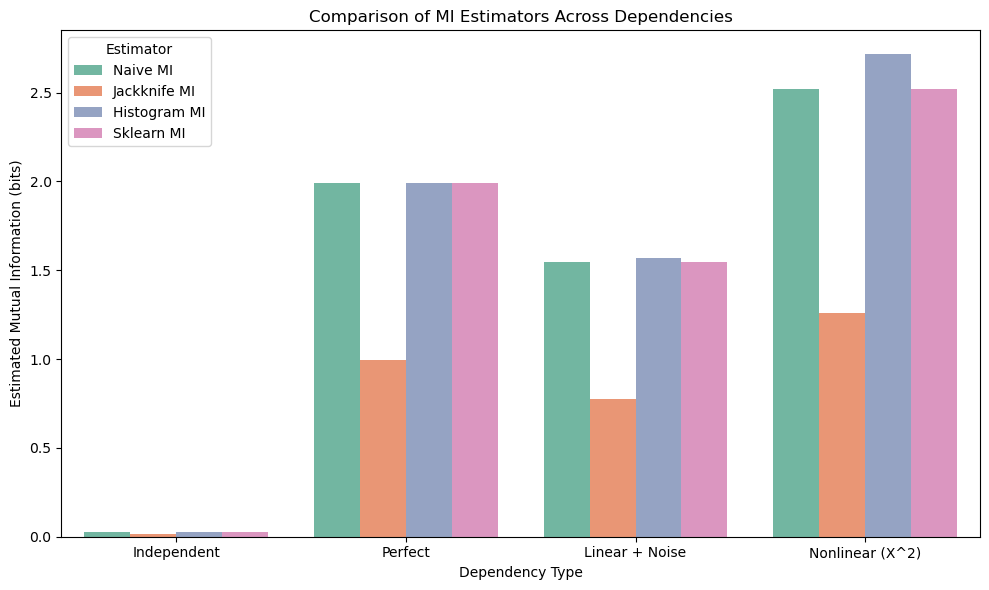

In [18]:
# Reshape DataFrame for Seaborn
df_plot = df_dep_results.melt(id_vars=["Dependency"],
                              value_vars=["Naive MI", "Jackknife MI", "Histogram MI", "Sklearn MI"],
                              var_name="Estimator",
                              value_name="MI Estimate")

plt.figure(figsize=(10, 6))
sns.barplot(data=df_plot, x="Dependency", y="MI Estimate", hue="Estimator", palette="Set2")

plt.title("Comparison of MI Estimators Across Dependencies")
plt.ylabel("Estimated Mutual Information (bits)")
plt.xlabel("Dependency Type")
plt.legend(title="Estimator")
plt.tight_layout()
plt.show()

In [ ]:
print(df_dep_results.round(3))

        Dependency  Naive MI  Jackknife MI  Histogram MI  Sklearn MI
0      Independent     0.029         0.015         0.029       0.029
1          Perfect     1.994         0.997         1.994       1.994
2   Linear + Noise     1.549         0.778         1.567       1.549
3  Nonlinear (X^2)     2.520         1.262         2.715       2.520


From above results:

1. Independent (True MI = 0)
All methods except Jackknife give ~0.025 (a small positive value), even though true MI is 0. Jackknife MI gives a value closer to 0 i.e less bias.

Conclusion: Jackknife helps correct the upward bias that occurs with finite samples in naive MI.

2. Perfect (True MI = log₂(4) = 2.0 bits)
Naive, Histogram, Sklearn MI ≈ 1.99, very close to 2.
Jackknife MI = 0.995 — almost half.

The jackknife estimator might be overcorrecting here as Jackknifing removes one point at a time which reduces perfect matching in a small sample. This causes an underestimate, especially in deterministic or low-entropy settings.

Conclusion: In perfect dependency, jackknife can introduce downward bias

3. Linear + Noise (True MI unknown, but expected: moderate)
Histogram: 1.589 (highest)
Naive & Sklearn: 1.532
Jackknife: 0.769 (again, much lower)

Conclusion: Jackknife seems to underestimate in this noisy setting.
Other methods are consistent, and Histogram tends to overestimate a bit.

4. Nonlinear (X² transformation)
Histogram: 2.682 (overestimated)
Naive & Sklearn: 2.472
Jackknife: 1.238

Conclusion: Jackknife again gives a much lower estimate. Others overestimate due to the complexity of the relationship and binning issues.

We can draw conclusion that jackknife works best when we want to correct positive bias in MI due to small sample sizes and when the data is noisy or nearly independent.

Quantifying bias

In [10]:
# Estimators dictionary
estimators = {
    "Naive MI": mutual_information,
    "Jackknife MI": lambda X, Y: jackknife_mi(X, Y, mutual_information),
    "Histogram MI": lambda X, Y: histogram_mi(
        X + 0.01 * np.random.randn(len(X)),
        Y + 0.01 * np.random.randn(len(Y)),
        bins=4
    ),
    "Sklearn MI": lambda X, Y: mutual_info_score(X, Y) / np.log(2)
}

In [15]:
# True MI values
true_mi_values = {
    "Independent": 0.0,
    "Perfect": np.log2(4)  # Perfect dependence: 2 bits
}

# Data generators
dependencies = {
    "Independent": lambda n: (np.random.choice(4, n), np.random.choice(4, n)),
    "Perfect": lambda n: (X := np.random.choice(4, n), X.copy())
}

In [ ]:
sample_size = 200
trials = 30
results = []

for dep_name, generator in dependencies.items():
    X, Y = generator(sample_size)
    true_mi = true_mi_values[dep_name]
    
    for est_name, est_func in estimators.items():
        estimates = []
        for _ in range(trials):
            X, Y = generator(sample_size)
            est_mi = est_func(X, Y)
            estimates.append(est_mi)

        estimates = np.array(estimates)
        mean_est = np.mean(estimates)
        std_est = np.std(estimates)
        bias = mean_est - true_mi

        results.append({
            "Dependency": dep_name,
            "Estimator": est_name,
            "Mean MI": mean_est,
            "True MI": true_mi,
            "Bias": bias,
            "Std Dev": std_est
        })

# DataFrame
df_bias = pd.DataFrame(results)
print(df_bias)

    Dependency     Estimator   Mean MI  True MI      Bias   Std Dev
0  Independent      Naive MI  0.033257      0.0  0.033257  0.016252
1  Independent  Jackknife MI  0.016220      0.0  0.016220  0.019599
2  Independent  Histogram MI  0.031191      0.0  0.031191  0.015756
3  Independent    Sklearn MI  0.036485      0.0  0.036485  0.016698
4      Perfect      Naive MI  1.985238      2.0 -0.014762  0.012000
5      Perfect  Jackknife MI  0.995754      2.0 -1.004246  0.995639
6      Perfect  Histogram MI  1.992404      2.0 -0.007596  0.006472
7      Perfect    Sklearn MI  1.990820      2.0 -0.009180  0.006097


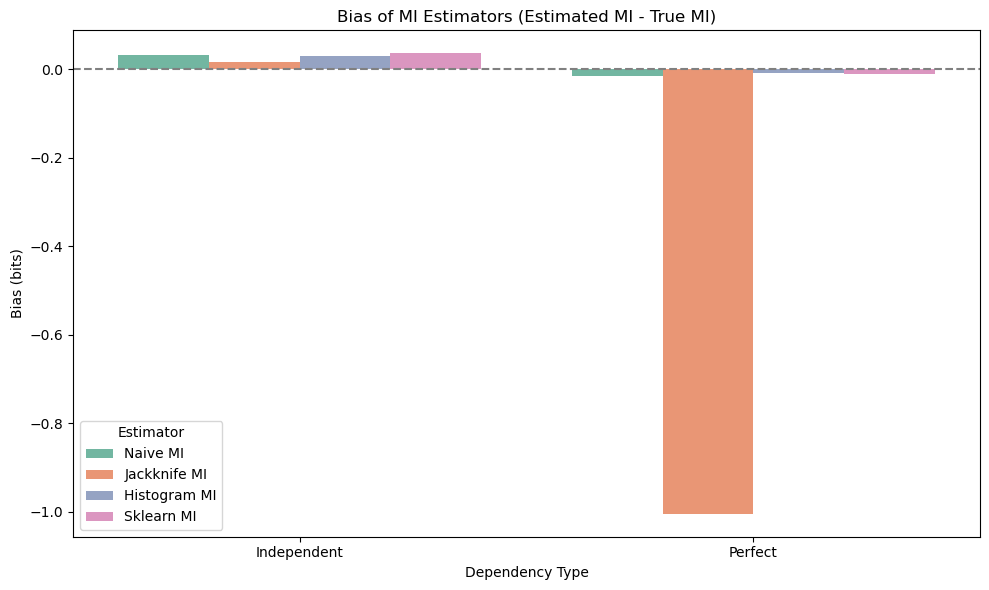

In [ ]:
# Visualizing bias
plt.figure(figsize=(10, 6))
sns.barplot(data=df_bias, x="Dependency", y="Bias", hue="Estimator", palette="Set2")
plt.axhline(0, color='gray', linestyle='--')
plt.title("Bias of MI Estimators (Estimated MI - True MI)")
plt.ylabel("Bias (bits)")
plt.xlabel("Dependency Type")
plt.legend(title="Estimator")
plt.tight_layout()
plt.show()

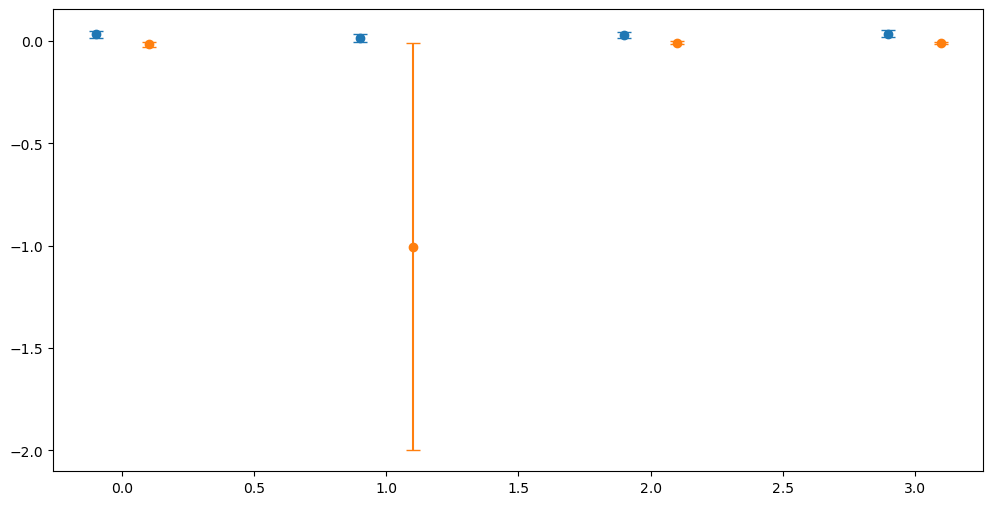

In [ ]:
# Plots with error bars
plt.figure(figsize=(12, 6))
for dep in df_bias["Dependency"].unique():
    subset = df_bias[df_bias["Dependency"] == dep]
    x = np.arange(len(subset))
    plt.errorbar(
        x + (0.1 if dep == "Perfect" else -0.1),  # offset bars
        subset["Bias"],
        yerr=subset["Std Dev"],
        fmt='o',
        capsize=5,
        label=f"{dep}",
    )


Bias tells us how wrong the average estimate is from the ground truth.
Std Dev tells us how stable or consistent the estimator is across repeated sampling.
Jackknife worked well for detecting independence (low MI), but performed poorly for high-MI scenarios.

For different sample sizes

In [13]:
# Data generators
def generate_independent(n):
    X = np.random.randint(0, 4, n)
    Y = np.random.randint(0, 4, n)
    return X, Y

def generate_perfect(n):
    X = np.random.randint(0, 4, n)
    return X, X.copy()

# True MI values
true_mi_values = {
    "Independent": 0.0,
    "Perfect": 2.0
}

In [7]:
estimators = {
    "Naive MI": lambda X, Y: float(mutual_information(X, Y)),
    "Jackknife MI": lambda X, Y: float(jackknife_mi(X, Y, mutual_information)[0]),  # Take only estimate
    "Histogram MI": lambda X, Y: float(histogram_mi(X + 0.01*np.random.randn(len(X)), 
                                                    Y + 0.01*np.random.randn(len(Y)), bins=4)),
    "Sklearn MI": lambda X, Y: float(mutual_info_score(X, Y) / np.log(2))
}


In [8]:
# Sample sizes to test
sample_sizes = [50, 100, 200, 500, 1000]
trials = 20
dependency = "Perfect"  # or "Independent"
generator = generate_perfect if dependency == "Perfect" else generate_independent
true_mi = true_mi_values[dependency]

results = []


In [ ]:
for sample_size in sample_sizes:
    for est_name, est_func in estimators.items():
        biases = []
        for _ in range(trials):
            X, Y = generator(sample_size)
            mi_est = est_func(X, Y)
            bias = mi_est - true_mi
            biases.append(bias)
        mean_bias = np.mean(biases)
        std_bias = np.std(biases)
        mse = mean_bias**2 + std_bias**2
        results.append({
            "Sample Size": sample_size,
            "Estimator": est_name,
            "Mean Bias": mean_bias,
            "Std Dev": std_bias,
            "MSE": mse
        })

df_sizes = pd.DataFrame(results)

In [10]:
df_sizes

,Sample Size,Estimator,Mean Bias,Std Dev,MSE
0,50,Naive MI,-0.039080,0.021531,0.001991
1,50,Jackknife MI,-0.043860,0.034398,0.003107
2,50,Histogram MI,-0.028686,0.024942,0.001445
3,50,Sklearn MI,-0.048221,0.027798,0.003098
4,100,Naive MI,-0.026421,0.015533,0.000939
5,100,Jackknife MI,-0.024040,0.014430,0.000786
6,100,Histogram MI,-0.024005,0.019221,0.000946
7,100,Sklearn MI,-0.019391,0.015014,0.000601
8,200,Naive MI,-0.008789,0.006580,0.000121
9,200,Jackknife MI,-0.013890,0.010027,0.000293


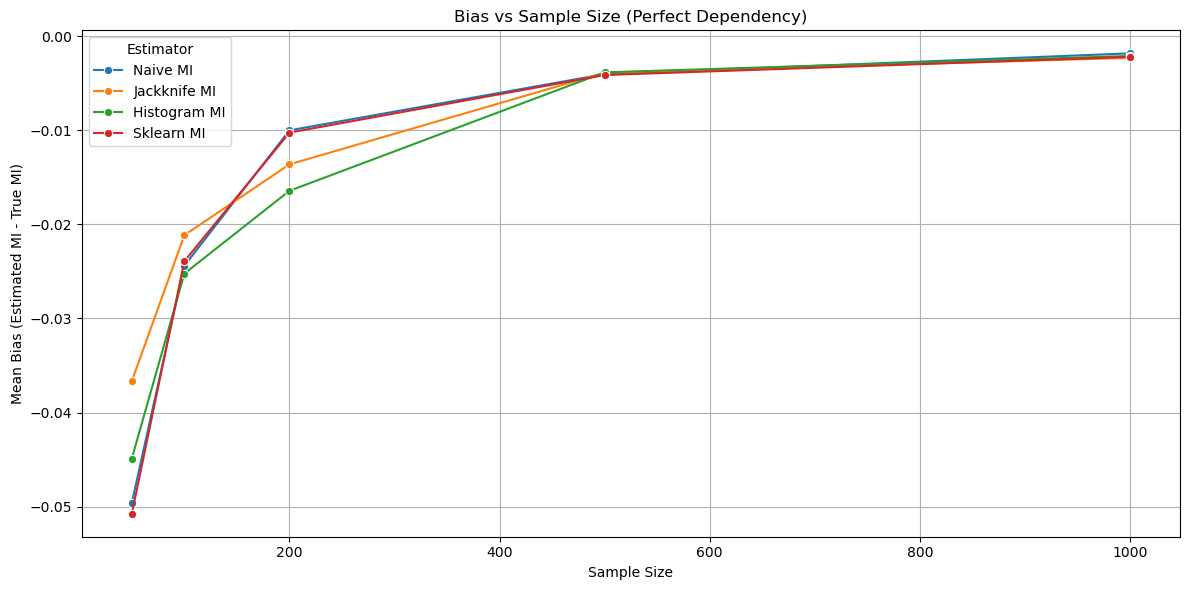

In [32]:
# Visualization
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_sizes, x="Sample Size", y="Mean Bias", hue="Estimator", marker="o")
plt.title(f"Bias vs Sample Size ({dependency} Dependency)")
plt.ylabel("Mean Bias (Estimated MI - True MI)")
plt.xlabel("Sample Size")
plt.grid(True)
plt.tight_layout()
plt.show()

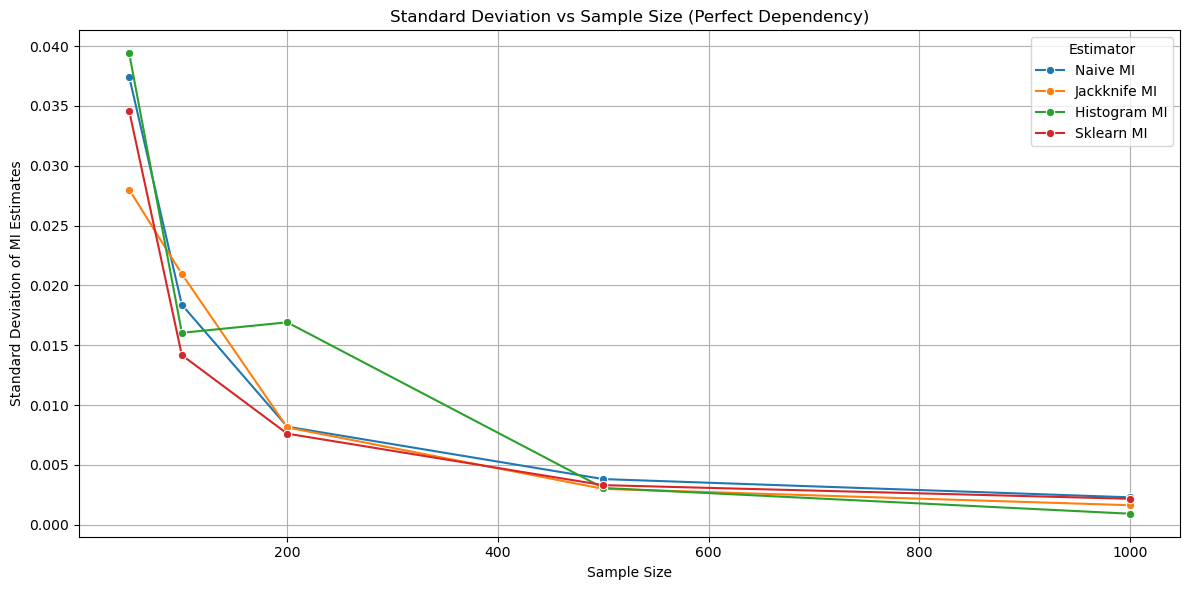

In [33]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_sizes, x="Sample Size", y="Std Dev", hue="Estimator", marker="o")
plt.title(f"Standard Deviation vs Sample Size ({dependency} Dependency)")
plt.ylabel("Standard Deviation of MI Estimates")
plt.xlabel("Sample Size")
plt.grid(True)
plt.tight_layout()
plt.show()

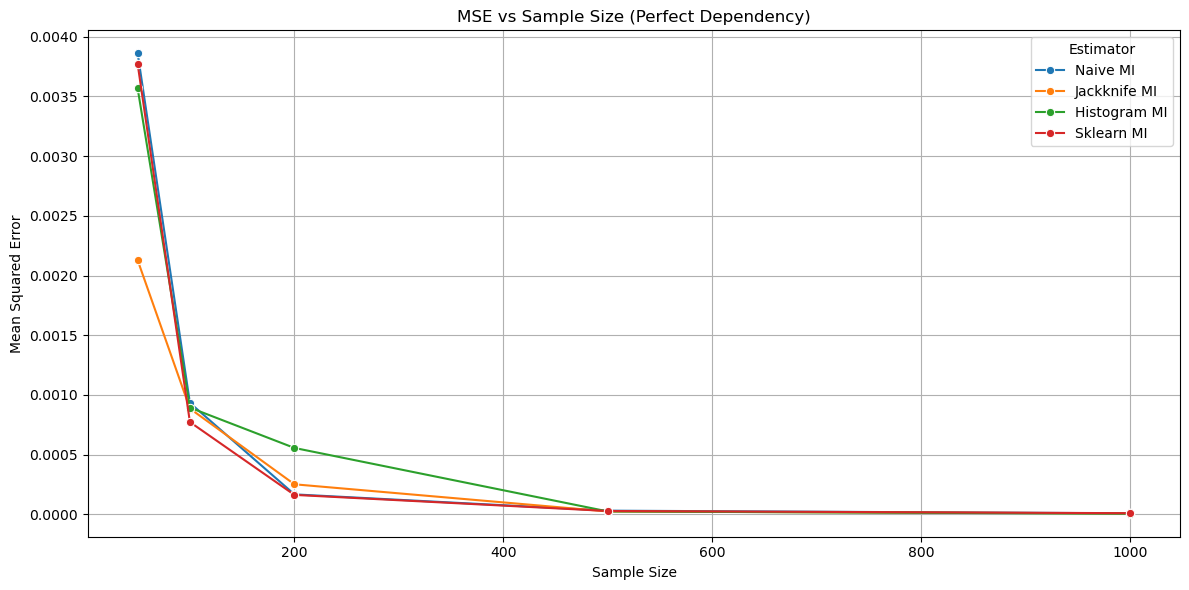

In [34]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_sizes, x="Sample Size", y="MSE", hue="Estimator", marker="o")
plt.title(f"MSE vs Sample Size ({dependency} Dependency)")
plt.ylabel("Mean Squared Error")
plt.xlabel("Sample Size")
plt.grid(True)
plt.tight_layout()
plt.show()

Compairing with bootstrap resampling

In [22]:
def bootstrap_mi(X, Y, base_mi_func, n_boot=100):
    n = len(X)
    mi_vals = []
    for _ in range(n_boot):
        idx = np.random.choice(n, n, replace=True)
        mi_vals.append(base_mi_func(X[idx], Y[idx]))
    return np.mean(mi_vals), np.var(mi_vals)

In [ ]:
# Data generators
def generate_independent(n): return np.random.randint(0, 5, size=n), np.random.randint(0, 5, size=n)
def generate_perfect(n): x = np.random.randint(0, 5, size=n); return x, x
def generate_noisy_linear(n): x = np.random.rand(n); return x, x + 0.1 * np.random.randn(n)
def generate_non_linear(n): x = np.random.rand(n); return x, np.sin(2 * np.pi * x) + 0.1 * np.random.randn(n)


In [ ]:
dependencies = {
    "Independent": generate_independent,
    "Perfect": generate_perfect,
    "Noisy Linear": generate_noisy_linear,
    "Non-linear": generate_non_linear
}

true_mi_values = {"Independent": 0.0, "Perfect": 2.0}
sample_sizes = [50, 100, 200, 500]
trials = 30
results = []

In [ ]:
for dep_name, generator in dependencies.items():
    for sample_size in sample_sizes:
        for method in ["Jackknife", "Bootstrap"]:
            biases, stds = [], []
            for _ in range(trials):
                X, Y = generator(sample_size)

                if dep_name in ["Independent", "Perfect"]:
                    Xb, Yb = X, Y
                else:
                    Xb = np.digitize((X - X.min()) / (X.max() - X.min()), np.linspace(0, 1, 10))
                    Yb = np.digitize((Y - Y.min()) / (Y.max() - Y.min()), np.linspace(0, 1, 10))

                if method == "Jackknife":
                    est, _ = jackknife_mi(Xb, Yb, mutual_information)
                else:
                    est, _ = bootstrap_mi(Xb, Yb, mutual_information)

                true_mi = true_mi_values.get(dep_name)
                if true_mi is not None:
                    bias = est - true_mi
                else:
                    bias = est

                biases.append(bias)

            mean_bias = np.mean(biases)
            std = np.std(biases)
            mse = mean_bias**2 + std**2

            results.append({
                "Dependency": dep_name,
                "Sample Size": sample_size,
                "Method": method,
                "Mean Bias": mean_bias,
                "Std Dev": std,
                "MSE": mse
            })

df_compare = pd.DataFrame(results)
print(df_compare)

      Dependency  Sample Size     Method  Mean Bias   Std Dev       MSE
0    Independent           50  Jackknife   0.246354  0.072836  0.065996
1    Independent           50  Jackknife   0.303811  0.087269  0.099917
2    Independent           50  Bootstrap   0.508048  0.062664  0.262040
3    Independent          100  Jackknife   0.130876  0.052309  0.019865
4    Independent          100  Bootstrap   0.243179  0.036917  0.060499
5    Independent          200  Jackknife   0.058613  0.020628  0.003861
6    Independent          200  Bootstrap   0.122164  0.022405  0.015426
7    Independent          500  Jackknife   0.020117  0.006139  0.000442
8    Independent          500  Bootstrap   0.047874  0.007972  0.002356
9        Perfect           50  Jackknife   0.259450  0.043758  0.069229
10       Perfect           50  Bootstrap   0.220967  0.032078  0.049855
11       Perfect          100  Jackknife   0.293773  0.015013  0.086528
12       Perfect          100  Bootstrap   0.260615  0.023600  0

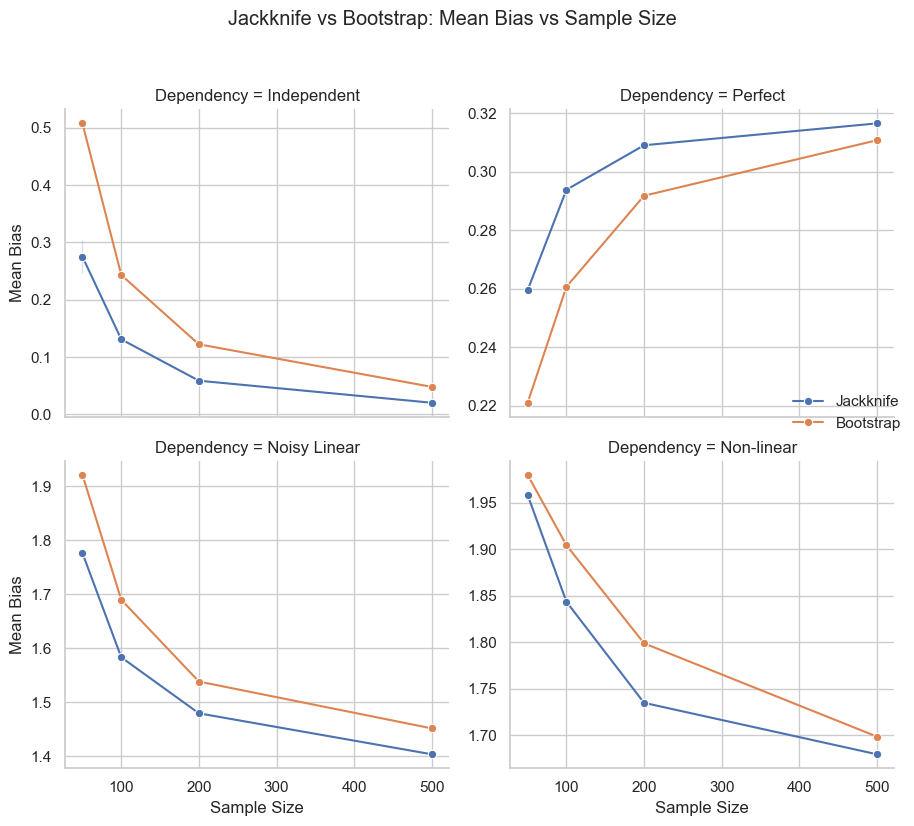

In [26]:
sns.set(style="whitegrid")
g = sns.FacetGrid(df_compare, col="Dependency", col_wrap=2, height=4, sharey=False)
g.map_dataframe(sns.lineplot, x="Sample Size", y="Mean Bias", hue="Method", marker="o")
g.add_legend()
g.set_axis_labels("Sample Size", "Mean Bias")
g.fig.suptitle("Jackknife vs Bootstrap: Mean Bias vs Sample Size", y=1.03)
plt.tight_layout()
plt.show()


For Independent variables: Jackknife consistently produces lower bias, lower variance, and lower MSE for independent variables. It's more accurate in identifying when there's no actual dependency.

For Perfect dependency: Both methods underestimate the true MI, but Bootstrap performs slightly better, especially in mean bias and MSE.

For Noisy Linear Dependency: Jackknife performs slightly better across all sizes, offering lower bias and MSE. Its more robust against noise in linear relationships.

For Non-Linear Dependency: Very close results, but Jackknife tends to edge out Bootstrap in most sample sizes by having slightly lower bias and MSE.


Jackknife is more and consistent for low or moderate MI values.
Bootstrap performs better when MI is very high, like in perfectly dependent data.
For real-world noisy data, Jackknife is safer due to lower variance and more stable bias.
As sample size increases, both methods improve — but Jackknife often converges faster.